# Project 7: Plant Seedling Classification using Convolutional Neural Networks

**Background:** Can we differentiate a weed from a crop seedling?
The ability to do so effectively can mean better crop yields and better stewardship of the environment.
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages.

**Objective:** Using a convolutional neural network (CNN) implemented through Tensorflow and Keras, identify the species of a seedling given an input image.

The project will be broken into several parts:

1. [Import the libraries and datasets](#1)
2. [Data Preprocessing](#2)
2. [Assemble Training, Validation, and Test Sets](#3)
3. [Model Building](#4)
4. [Model Fitting and Evaluation](#5)
5. [Visualize Predictions](#6)


<a id="1"></a>
## Section 1: Import Libraries and Datsets

In [ ]:
import pandas as pd
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# configure visualization defaults
plt.style.use('ggplot')
%matplotlib inline

# scoring metrics
from sklearn.metrics import confusion_matrix

# data preprocessing
from cv2 import GaussianBlur
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
import warnings; warnings.simplefilter('ignore')


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load images
X = np.load("/content/gdrive/My Drive/PMP AIML/CNNS/images.npy")
X.shape

(4750, 128, 128, 3)

Our input data X consists of 4,750 color images that contain 128 x 128 x 3 pixels each.

In [ ]:
# Load labels
labels = pd.read_csv("/content/gdrive/My Drive/PMP AIML/CNNS/Labels.csv")

print("The Labels dataset set contains {:,} labels.".format(labels.shape[0]))
print("There are {} unique species.".format(labels.nunique()[0]))

The Labels dataset set contains 4,750 labels.
There are 12 unique species.


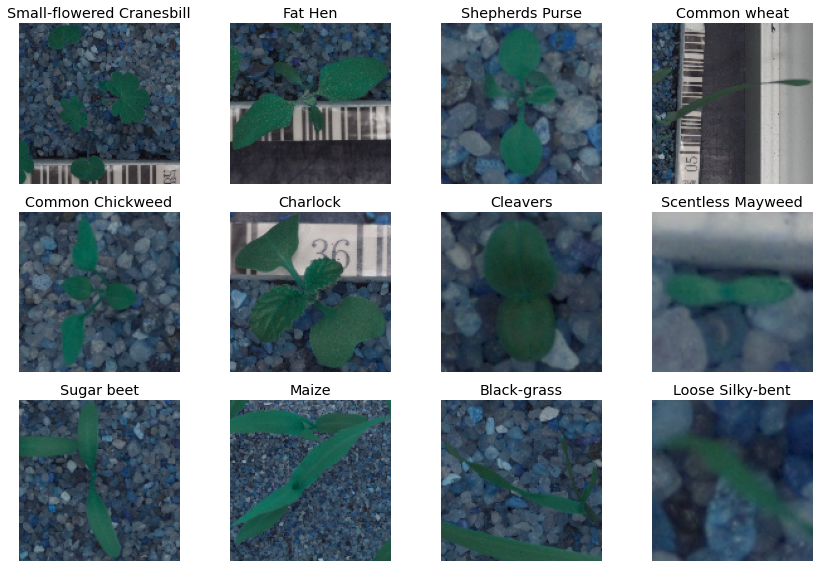

In [ ]:
import random
random.seed(1)

species_index = [random.choice(labels[labels.Label==species].index) for species in labels.Label.unique()]

fig = plt.figure(figsize=(12, 8))

for idx, (image, label) in enumerate(zip(X[species_index],labels.Label.iloc[species_index])):
  ax = fig.add_subplot(3, 4, idx+1)
  plt.imshow(image)
  plt.axis('off')
  ax.set_title(label);

plt.tight_layout()

<a id="2"></a>
## Section 2: Data Preprocessing

### 2.a Normalize Data

In [ ]:
# Convert pixel values to float
X = X.astype('float32')

# Normalize pixel values
X /= 255

### 2.b Guassian Blurring

In [ ]:
X_blurred = np.zeros(shape=X.shape)

for i in range(X.shape[0]):
  X_blurred[i] = GaussianBlur(X[i],(5,5),0);

### 2.c Images After Normalization and Blurring

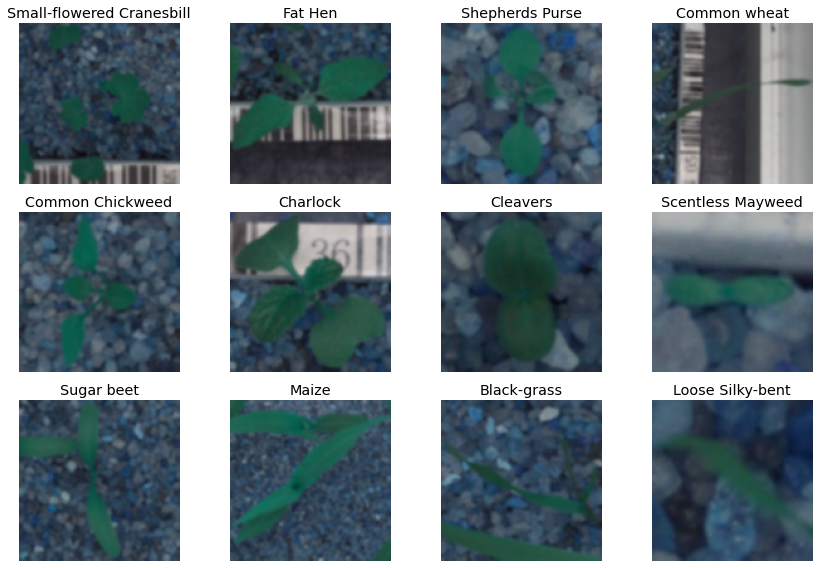

In [ ]:
fig = plt.figure(figsize=(12, 8))

for idx, (image, label) in enumerate(zip(X_blurred[species_index],labels.Label.iloc[species_index])):
  ax = fig.add_subplot(3, 4, idx+1)
  plt.imshow(image)
  plt.axis('off')
  ax.set_title(label);

plt.tight_layout()

<a id="3"></a>
## Section 3: Prepare Train, Validation, and Test Sets

### 3.a Convert labels to one-hot vectors

In [ ]:
one_hot = OneHotEncoder()
y = one_hot.fit_transform(labels).toarray()
print("Shape of y: ", y.shape)

Shape of y:  (4750, 12)


### 3.b Print Label for y_train[0]

In [ ]:
print("One-hot encoding for the first image: ",y[0])
print("First image label: ",labels.Label.iloc[0])

One-hot encoding for the first image:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
First image label:  Small-flowered Cranesbill


### 3.c Split Data into Train, Validation, and Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_blurred, y, test_size=0.3, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

### 3.d Check Shape of the Data

In [ ]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_val shape: ",X_val.shape)
print("y_val shape: ",y_val.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (3325, 128, 128, 3)
y_train shape:  (3325, 12)
X_val shape:  (712, 128, 128, 3)
y_val shape:  (712, 12)
X_test shape:  (713, 128, 128, 3)
y_test shape:  (713, 12)


All of the arrays are in the correct shape

<a id="4"></a>
## Section 4: Model Building
### 4.a Define Layers

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(rate=0.5),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(rate=0.5),
    
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), padding='same', activation='relu'),

    GlobalMaxPooling2D(),

    Dense(256, activation="relu"),
    Dropout(0.25),

    Dense(12, activation="softmax")

])

model.build(input_shape=(None, 128, 128, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

### 4.b Set Optimizer and Loss Function

In [ ]:
# Compile the model
model.compile(
    optimizer = optimizers.Adam(lr = 0.001),
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

<a id="5"></a>
## Section 5: Model Training and Evaluation

In [ ]:
# Fit the model
model.fit(x=X_train, 
          y=y_train, 
          batch_size=32, 
          epochs=30,  
          validation_data=(X_val, y_val)
          )

Epoch 1/30
104/104 [==============================] - 3s 24ms/step - loss: 2.4567 - accuracy: 0.1335 - val_loss: 2.4497 - val_accuracy: 0.1208
Epoch 2/30
104/104 [==============================] - 2s 22ms/step - loss: 2.4209 - accuracy: 0.1351 - val_loss: 2.4423 - val_accuracy: 0.2008
Epoch 3/30
104/104 [==============================] - 2s 21ms/step - loss: 2.3131 - accuracy: 0.2047 - val_loss: 1.9772 - val_accuracy: 0.3160
Epoch 4/30
104/104 [==============================] - 2s 22ms/step - loss: 1.8871 - accuracy: 0.3174 - val_loss: 1.8315 - val_accuracy: 0.3357
Epoch 5/30
104/104 [==============================] - 2s 22ms/step - loss: 1.7760 - accuracy: 0.3581 - val_loss: 1.8362 - val_accuracy: 0.3118
Epoch 6/30
104/104 [==============================] - 2s 22ms/step - loss: 1.6818 - accuracy: 0.3943 - val_loss: 1.7423 - val_accuracy: 0.4157
Epoch 7/30
104/104 [==============================] - 2s 21ms/step - loss: 1.5207 - accuracy: 0.4622 - val_loss: 1.4565 - val_accuracy: 0.4888

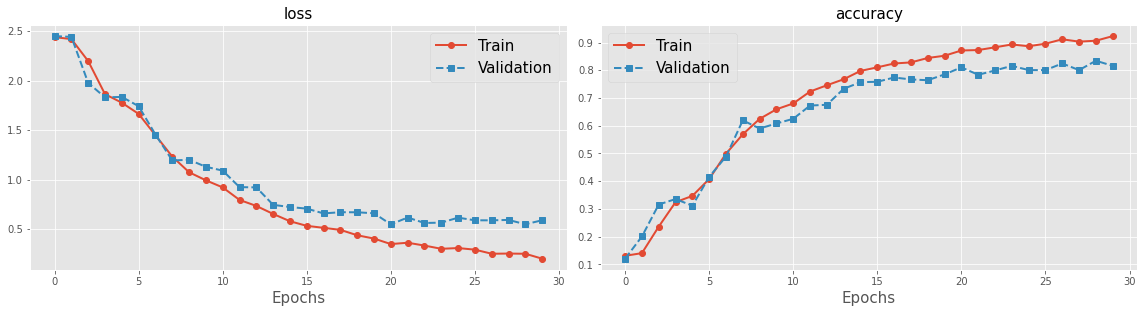

In [ ]:
train_hist = list(model.history.history.keys())[:2]
val_hist = list(model.history.history.keys())[2:]

fig = plt.figure(figsize=(16, 8))

for idx, (train, val) in enumerate(zip(train_hist,val_hist)):
    
    ax = fig.add_subplot(2, 2, idx+1)
    plt.plot(model.history.history[train], '-o', lw=2)
    plt.plot(model.history.history[val],'--s', lw=2)
    plt.legend(['Train', 'Validation'], fontsize=15)
    ax.set_xlabel('Epochs', size=15);
    ax.set_title(train,size=15);


plt.tight_layout()

The model is performing well as can be seen by the monotonic decrease of both the training and validation loss. Accuracy performance on the validation set stagnates after approximately 25 epochs so stopping training at this point makes sense. 

In [ ]:
# make class predictions
y_pred = model.predict_classes(X_test)

# grab true labels
y_true = np.argmax(y_test, axis=1)

# model evaluation on the test set
model.evaluate(x=X_test, y=y_test)

23/23 [==============================] - 0s 8ms/step - loss: 0.5873 - accuracy: 0.8415


[0.5872700810432434, 0.8415147066116333]

The model achieves an accuracy of 84% on the test set which is 
close to the accuracy we were seeing on the validation set.

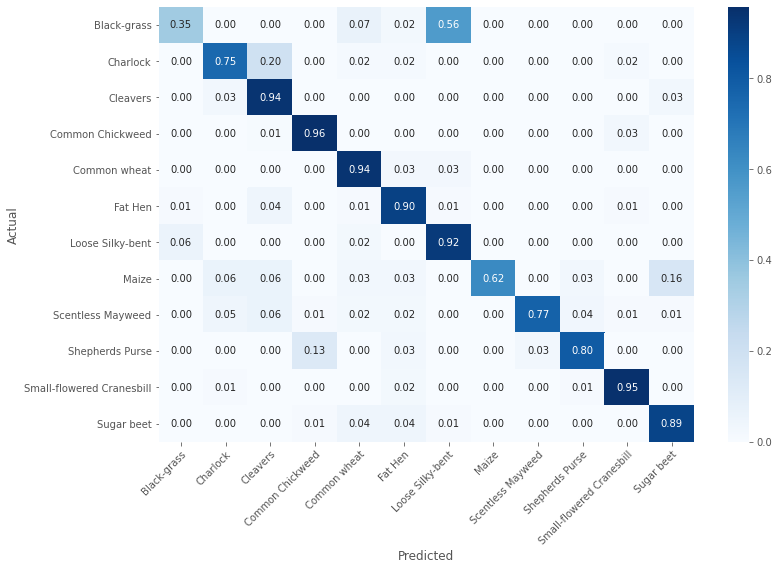

In [ ]:
class_names = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
        'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
        'Scentless Mayweed', 'Shepherds Purse',
        'Small-flowered Cranesbill', 'Sugar beet']

# create confusion matrix using the test set
confmat = confusion_matrix(y_true,y_pred, normalize='true')

# plot heatmap
fig, ax = plt.subplots(figsize=(12,8));
sns.heatmap(confmat, annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names, fmt = '.2f');
ax.set_xlabel("Predicted");
ax.set_ylabel("Actual");
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");

The model identifies most species quite accurately save for Black-grass and Maize. All other species are correctly identified with an accuracy of 75% or higher.

<a id="6"></a>
## Section 5: Visualize Predictions

Below we compare the predicted classes to the actual classes. To do so, we first grab a representative image for the predicted class then compare it to the image of the actual class. We consider five different comparisons.

In [ ]:
def image_comparison(idx):

  # predicted class for X_test[idx]
  pred_class = class_names[y_pred[idx]] 

  # actual class
  actual_class = class_names[y_true[idx]] 

  # find representative image for the predicted class to use for comparison
  img_idx = labels[labels.Label==pred_class].index[0] 

  fig, axes = plt.subplots(1, 2, figsize=(8, 8))

  # show representative image of predicted class
  axes[0].imshow(X[img_idx]);

  # show actual image
  axes[1].imshow(X_test[idx]);

  axes[0].grid(False);
  axes[0].set_title("Predicted Class: \n {}".format(pred_class))
  axes[1].grid(False);
  axes[1].set_title("Actual Class: \n {}".format(actual_class))
  axes[1].set_ylabel("Test Image {}".format(idx))

  plt.tight_layout()


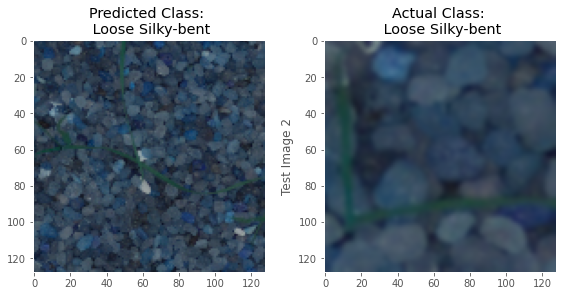

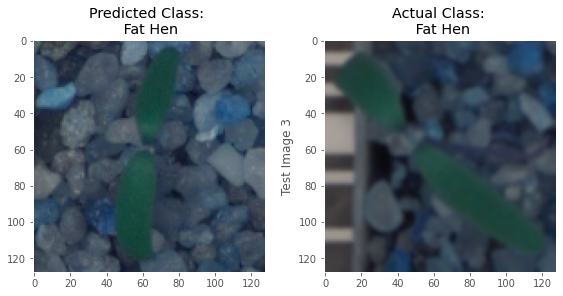

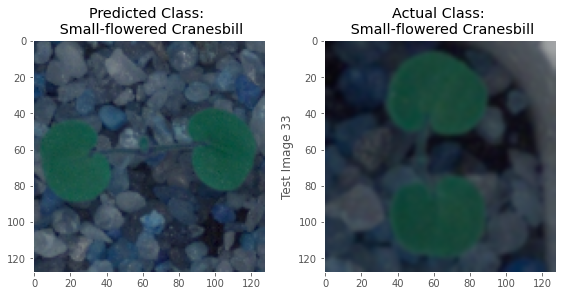

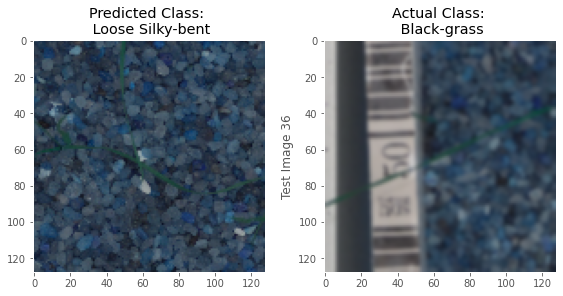

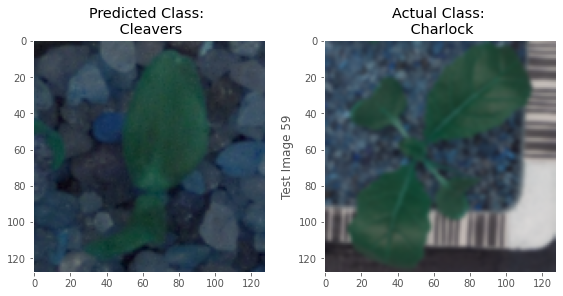

In [ ]:
test_img_idx = [2, 3, 33, 36, 59]

for i in test_img_idx:
  image_comparison(i)